---
# Portfolio Backtest with Backtrader
---

In [2]:
import pandas as pd
import datetime
import yfinance as yf
import backtrader as bt
import numpy as np
import riskfolio.PlotFunctions as plf
import matplotlib.pyplot as plt
from matplotlib.dates import (HOURS_PER_DAY, MIN_PER_HOUR, SEC_PER_MIN,
                              MONTHS_PER_YEAR, DAYS_PER_WEEK,
                              SEC_PER_HOUR, SEC_PER_DAY,
                              num2date, rrulewrapper, YearLocator,
                              MicrosecondLocator)

%matplotlib inline

In [28]:
# Pandas_datareader override
yf.pdr_override()
pd.options.display.float_format = '{:.4f}'.format

In [29]:
# Date range
start = '2016-01-01'
end = '2021-08-16'

## Select asset tickers
assets = ['BRK-B','ARKK','AGG','ETH-USD','QQQ','SPY']
assets.sort()

prices = yf.download(assets, start=start, end=end)
prices = prices.dropna()
prices.tail()

[*********************100%***********************]  6 of 6 completed


Adj Close                                                  Close  \
                 AGG     ARKK    BRK-B   ETH-USD      QQQ      SPY      AGG   
Date                                                                          
2021-08-09  115.5800 124.7000 287.2300 3167.8562 368.7300 442.1300 115.5800   
2021-08-10  115.4300 121.4400 288.9400 3141.6912 366.8400 442.6800 115.4300   
2021-08-11  115.5400 121.3000 291.2800 3164.2451 366.2100 443.7800 115.5400   
2021-08-12  115.5500 121.8500 290.2400 3043.4143 367.5300 445.1100 115.5500   
2021-08-13  115.9700 120.1000 287.8900 3322.2117 368.8200 445.9200 115.9700   

                                        ...     Open                     \
               ARKK    BRK-B   ETH-USD  ...    BRK-B   ETH-USD      QQQ   
Date                                    ...                               
2021-08-09 124.7000 287.2300 3167.8562  ... 287.8600 3012.8857 368.5200   
2021-08-10 121.4400 288.9400 3141.6912  ... 287.0100 3163.0500 369.2600   
2021-08-11 121.3000 291.2800 3164.2451  ... 289.4500 3142.8303 368.1400   
2021-08-12 121.8500 290.2400 3043.4143  ... 291.8100 3164.1758 365.6900   
2021-08-13 120.1000 287.8900 3322.2117  ... 290.6100 3049.0012 367.8900   

                          Volume                                             \
                SPY          AGG         ARKK        BRK-B          ETH-USD   
Date                                                                          
2021-08-09 442.4600 5298600.0000 4528100.0000 3676500.0000 31983260936.0000   
2021-08-10 442.6100 7332100.0000 5387100.0000 3134100.0000 27605221710.0000   
2021-08-11 443.8200 6674600.0000 6007900.0000 3475100.0000 26729035052.0000   
2021-08-12 443.6200 5017300.0000 3320300.0000 3170300.0000 25403699845.0000   
2021-08-13 445.5900 4599800.0000 3968800.0000 3115200.0000 23868866254.0000   

                                        
                     QQQ           SPY  
Date                                    
2021-08-09 25960200.0000 41222600.0000  
2021-08-10 35130800.0000 43339300.0000  
2021-08-11 34249800.0000 44034300.0000  
2021-08-12 25969200.0000 38909400.0000  
2021-08-13 19318800.0000 39388300.0000  

[5 rows x 36 columns]

---
# Backtest Function
---

In [30]:
# Defining the backtest function 
def backtest(datas, strategy, start, end, plot=False, **kwargs):
    cerebro = bt.Cerebro()

    # Here we add transaction costs and other broker costs
    cerebro.broker.setcash(1000000.0)
    cerebro.broker.setcommission(commission=0.005) # Commission 0.5%
    cerebro.broker.set_slippage_perc(0.005, # Slippage 0.5%
                                     slip_open=True,
                                     slip_limit=True,
                                     slip_match=True,
                                     slip_out=False)
    for data in datas:
        cerebro.adddata(data)

    # Here we add the indicators that we are going to store
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)
    cerebro.addanalyzer(bt.analyzers.Returns)
    cerebro.addanalyzer(bt.analyzers.DrawDown)
    cerebro.addstrategy(strategy, **kwargs)
    cerebro.addobserver(bt.observers.Value)
    cerebro.addobserver(bt.observers.DrawDown)
    results = cerebro.run(stdstats=False)
    if plot:
        cerebro.plot(iplot=False, start=start, end=end)
    return (results[0].analyzers.drawdown.get_analysis()['max']['drawdown'],
            results[0].analyzers.returns.get_analysis()['rnorm100'],
            results[0].analyzers.sharperatio.get_analysis()['sharperatio'])

In [37]:
# Create objects that contain the prices of assets

# Creating Assets bt.feeds
assets_prices = []
for i in assets:
    if i != 'SPY':
        prices_ = prices.drop(columns='Adj Close').loc[:, (slice(None), i)].dropna()
        prices_.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
        assets_prices.append(bt.feeds.PandasData(dataname=prices_, plot=False))
        

# Creating Benchmark bt.feeds        
prices_ = prices.drop(columns='Adj Close').loc[:, (slice(None), 'SPY')].dropna()
prices_.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
benchmark = bt.feeds.PandasData(dataname=prices_, plot=False)

prices_.head()

,Close,High,Low,Open,Volume
Date,,,,,
2016-01-04,201.0200,201.0300,198.5900,200.4900,222353500.0000
2016-01-05,201.3600,201.9000,200.0500,201.4000,110845800.0000
2016-01-06,198.8200,200.0600,197.6000,198.3400,152112600.0000
2016-01-07,194.0500,197.4400,193.5900,195.3300,213436100.0000
2016-01-08,191.9200,195.8500,191.5800,195.1900,209817200.0000


---
# Buy and Hold Strategy
---

In [38]:
class BuyAndHold(bt.Strategy):

    def __init__(self):
        self.counter = 0

    def next(self):
        if self.counter >= 1004:
            if self.getposition(self.data).size == 0:
                self.order_target_percent(self.data, target=0.99)
        self.counter += 1 

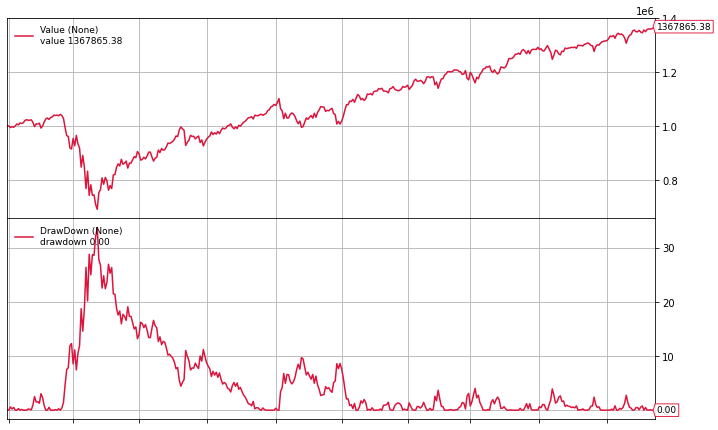

In [90]:
# Run the backtest for the selected period
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)

start = 1004
end = prices.shape[0] - 1

dd, cagr, sharpe = backtest([benchmark],
                            BuyAndHold,
                            start=start,
                            end=end,
                            plot=True)

In [41]:
# Buy and Hold Strategy Stats 
print(f"Max Drawdown: {dd:.2f}%")
print(f"CAGR: {cagr:.2f}%")
print(f"Sharpe: {sharpe:.2f}")

Max Drawdown: 33.72%
CAGR: 5.80%
Sharpe: 0.70


----
# Quarterly Rebalancing
----

In [42]:
# Calculate assets returns
pd.options.display.float_format = '{:.4%}'.format

data = prices.loc[:, ('Adj Close', slice(None))]
data.columns = assets
data = data.drop(columns=['SPY']).dropna()
returns = data.pct_change().dropna()
display(returns.head())

,AGG,ARKK,BRK-B,ETH-USD,QQQ
Date,,,,,
2016-01-05,0.0463%,0.7996%,0.3824%,-0.4509%,-0.1735%
2016-01-06,0.3796%,-1.6857%,0.0610%,0.0720%,-0.9606%
2016-01-07,-0.0092%,-3.9334%,-1.4087%,-0.9313%,-3.1314%
2016-01-08,0.2213%,-1.1548%,-0.8882%,4.7541%,-0.8201%
2016-01-11,-0.2853%,-3.5051%,0.0234%,7.5813%,0.3077%


In [43]:
# Selecting Dates for Rebalancing
# Selecting last day of month of available data
index = returns.groupby([returns.index.year, returns.index.month]).tail(1).index
index_2 = returns.index

# Quarterly Dates
index = [x for x in index if float(x.month) % 3.0 == 0 ] 

# Dates where the strategy will be backtested
index_ = [index_2.get_loc(x) for x in index if index_2.get_loc(x) > 1000]

----
# Portfolio Constraints
----

In [73]:
# Create constraints (you can create more detailed constraints - see example codes)
asset_classes = {'Assets': ['AGG', 'ARKK', 'BRK-B', 'ETH-USD','QQQ'],
                 'Class 1': ['Fixed Income', 'Equity', 'Equity', 'Crypto','Equity'],
                }
asset_classes = pd.DataFrame(asset_classes)
constraints = pd.read_excel('/Users/draganbogatic/Documents/Fin_Tech/portfolio_optimization/resources/constraints.xls',  index_col='Index')
constraints

,Disabled,Type,Set,Position,Sign,Weight,Type Relative,Relative Set,Relative,Factor
Index,,,,,,,,,,
0,False,Classes,Class 1,Equity,>=,60.0000%,nan%,nan%,nan%,nan%
1,False,Classes,Class 1,Fixed Income,<=,30.0000%,nan%,nan%,nan%,nan%
2,False,Classes,Class 1,Crypto,<=,3.0000%,nan%,nan%,nan%,nan%
3,False,Assets,NaN,BRK-B,>=,30.0000%,nan%,nan%,nan%,nan%
4,False,Assets,NaN,BRK-B,<=,50.0000%,nan%,nan%,nan%,nan%
5,False,Assets,NaN,QQQ,<=,30.0000%,nan%,nan%,nan%,nan%
6,False,Assets,NaN,QQQ,>=,15.0000%,nan%,nan%,nan%,nan%
7,False,Assets,NaN,ARKK,<=,30.0000%,nan%,nan%,nan%,nan%


In [74]:
# Building constraint matrixes for Riskfolio Lib
import riskfolio.ConstraintsFunctions as cf

A, B = cf.assets_constraints(constraints, asset_classes)
A,B

(array([[ 0,  1,  1,  0,  1],
        [-1,  0,  0,  0,  0],
        [ 0,  0,  0, -1,  0],
        [ 0,  0,  1,  0,  0],
        [ 0,  0, -1,  0,  0],
        [ 0,  0,  0,  0, -1],
        [ 0,  0,  0,  0,  1],
        [ 0, -1,  0,  0,  0]]),
 array([[ 0.6 ],
        [-0.3 ],
        [-0.03],
        [ 0.3 ],
        [-0.5 ],
        [-0.3 ],
        [ 0.15],
        [-0.3 ]]))

---
# Portfolio Optimization
---

In [75]:
%%time
# Building a loop that estimate optimal portfolios on
# rebalancing dates
import riskfolio.Portfolio as pf

models = {}

# rms = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM',
#        'CVaR', 'WR', 'MDD', 'ADD', 'CDaR']

rms = ['MV', 'CVaR', 'WR', 'CDaR']

for j in rms:
    
    weights = pd.DataFrame([])

    for i in index_:
        Y = returns.iloc[i-1000:i,:] # taking last 4 years (250 trading days per year)

        # Building the portfolio object
        port = pf.Portfolio(returns=Y)
        
        # Add portfolio constraints
        port.ainequality = A
        port.binequality = B
        
        # Calculating optimum portfolio

        # Select method and estimate input parameters:

        method_mu='hist' # Method to estimate expected returns based on historical data.
        method_cov='hist' # Method to estimate covariance matrix based on historical data.

        port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)
        
        # Estimate optimal portfolio:
        
        #port.solvers = ['MOSEK']
        port.alpha = 0.05
        model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
        rm = j # Risk measure used, this time will be variance
        obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
        hist = True # Use historical scenarios for risk measures that depend on scenarios
        rf = 0 # Risk free rate
        l = 0 # Risk aversion factor, only useful when obj is 'Utility'

        w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

        if w is None:
            w = weights.tail(1).T
        weights = pd.concat([weights, w.T], axis = 0)
    
    models[j] = weights.copy()
    models[j].index = index_

CPU times: user 9.86 s, sys: 239 ms, total: 10.1 s
Wall time: 1.79 s


In [76]:
display(models[j])

,AGG,ARKK,BRK-B,ETH-USD,QQQ
1003,30.0000%,20.6078%,31.3922%,3.0000%,15.0000%
1065,30.0000%,22.0000%,30.0000%,3.0000%,15.0000%
1127,30.0000%,22.0000%,30.0000%,3.0000%,15.0000%
1191,30.0000%,22.0000%,30.0000%,3.0000%,15.0000%
1252,30.0000%,22.0000%,30.0000%,3.0000%,15.0000%
1313,30.0000%,22.0000%,30.0000%,3.0000%,15.0000%
1376,30.0000%,22.0000%,30.0000%,3.0000%,15.0000%


In [77]:
class AssetAllocation(bt.Strategy):

    def __init__(self):

        j = 0
        for i in assets:
            setattr(self, i, self.datas[j])
            j += 1
        
        self.counter = 0
        
    def next(self):
        if self.counter in weights.index.tolist():
            for i in assets:
                w = weights.loc[self.counter, i]
                self.order_target_percent(getattr(self, i), target=w)
        self.counter += 1

---
# Mean-Variance Strategy
---

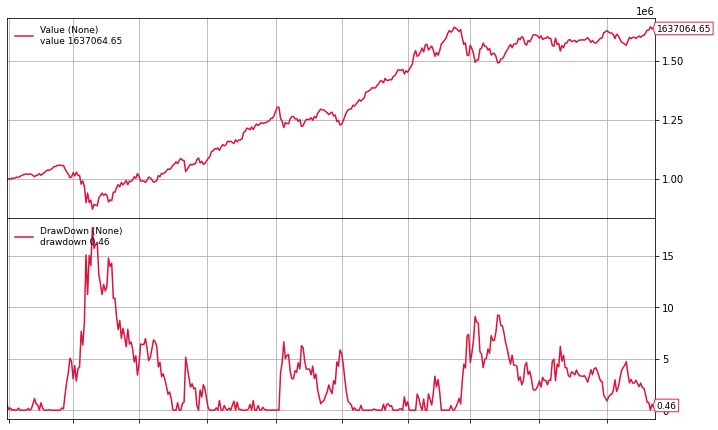

In [78]:
# Backtesting Mean Variance Strategy
assets = returns.columns.tolist()
weights = models['MV']

dd, cagr, sharpe = backtest(assets_prices,
                            AssetAllocation,
                            start=start,
                            end=end,
                            plot=True)

In [79]:
# Show Mean Variance Strategy Stats 
print(f"Max Drawdown: {dd:.2f}%")
print(f"CAGR: {cagr:.2f}%")
print(f"Sharpe: {sharpe:.3f}")

Max Drawdown: 17.72%
CAGR: 9.19%
Sharpe: 0.575


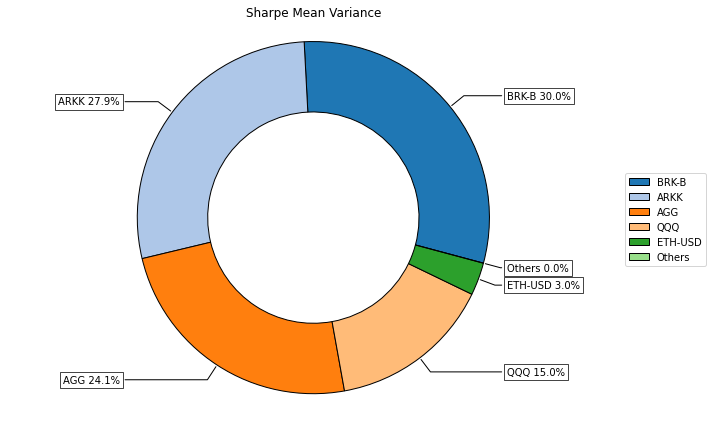

In [80]:
# Plotting the composition of the last MV portfolio
w = pd.DataFrame(models['MV'].iloc[-1,:])
plt.plot()

ax = plf.plot_pie(w=w, title='Sharpe Mean Variance', others=0.02, nrow=25, cmap = "tab20",
                  height=6, width=10, ax=None)

---
# Mean CVaR Strategy
---

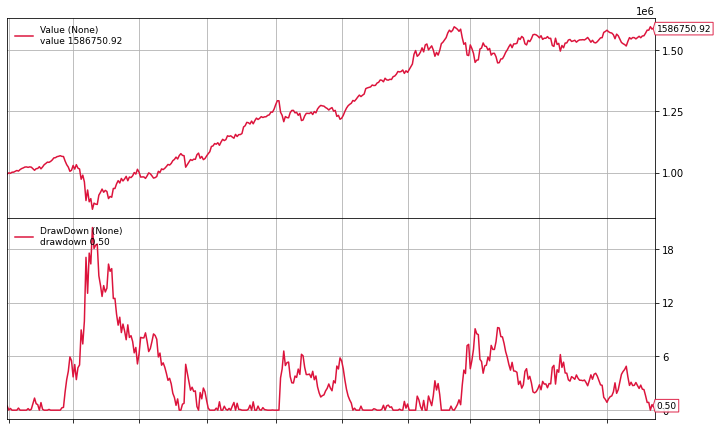

In [81]:
# Backtesting Mean CVaR Strategy
assets = returns.columns.tolist()
weights = models['CVaR']

dd, cagr, sharpe = backtest(assets_prices,
                            AssetAllocation,
                            start=start,
                            end=end,
                            plot=True)

In [82]:
# Show CVaR Strategy Stats 
print(f"Max Drawdown: {dd:.2f}%")
print(f"CAGR: {cagr:.2f}%")
print(f"Sharpe: {sharpe:.3f}")

Max Drawdown: 20.38%
CAGR: 8.57%
Sharpe: 0.583


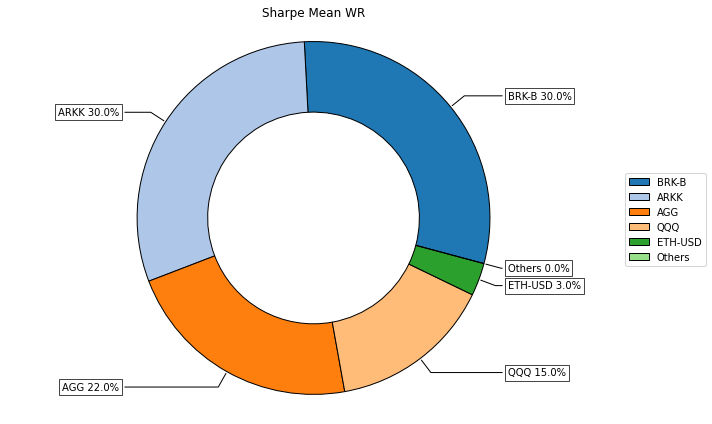

In [83]:
# Plotting the composition of the last WR portfolio
w = pd.DataFrame(models['CVaR'].iloc[-1,:])
ax = plf.plot_pie(w=w, title='Sharpe Mean WR', others=0.02, nrow=25, cmap = "tab20",
                  height=6, width=10, ax=None)

---
# Mean Worst Realization Strategy
---

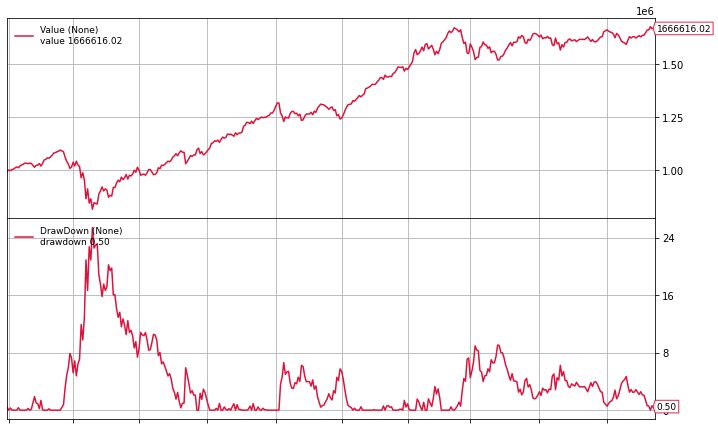

In [84]:
# Backtesting Mean Worst Realization Strategy
assets = returns.columns.tolist()
weights = models['WR']

dd, cagr, sharpe = backtest(assets_prices,
                            AssetAllocation,
                            start=start,
                            end=end,
                            plot=True)

In [85]:
# Show Worst Realization Strategy Stats 
print(f"Max Drawdown: {dd:.2f}%")
print(f"CAGR: {cagr:.2f}%")
print(f"Sharpe: {sharpe:.3f}")

Max Drawdown: 25.41%
CAGR: 9.52%
Sharpe: 0.573


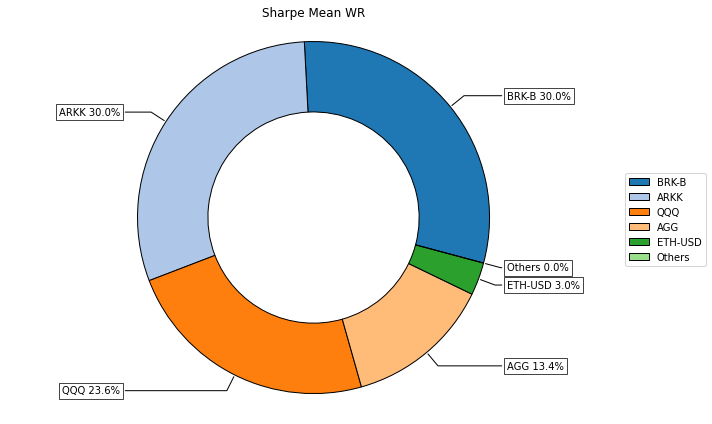

In [86]:
# Plotting the composition of the last WR portfolio
w = pd.DataFrame(models['WR'].iloc[-1,:])
ax = plf.plot_pie(w=w, title='Sharpe Mean WR', others=0.02, nrow=25, cmap = "tab20",
                  height=6, width=10, ax=None)


---
# Mean CDaR Strategy
---

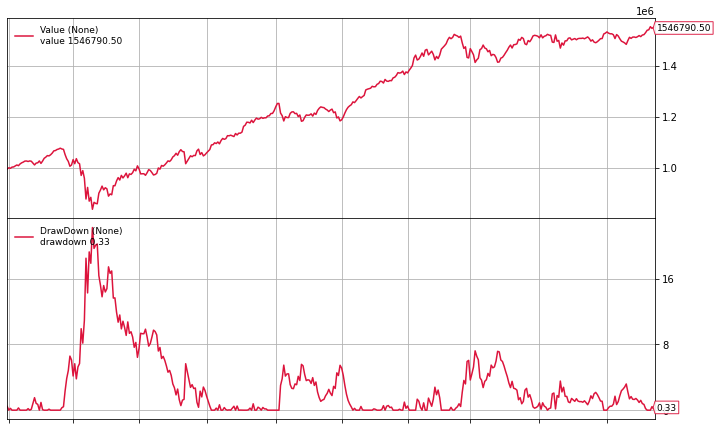

In [87]:
# Backtesting Mean CDaR Strategy
assets = returns.columns.tolist()
weights = models['CDaR']

dd, cagr, sharpe = backtest(assets_prices,
                            AssetAllocation,
                            start=start,
                            end=end,
                            plot=True)

In [88]:
# Show CDaR Strategy Stats 
print(f"Max Drawdown: {dd:.2f}%")
print(f"CAGR: {cagr:.2f}%")
print(f"Sharpe: {sharpe:.3f}")

Max Drawdown: 22.19%
CAGR: 8.11%
Sharpe: 0.597


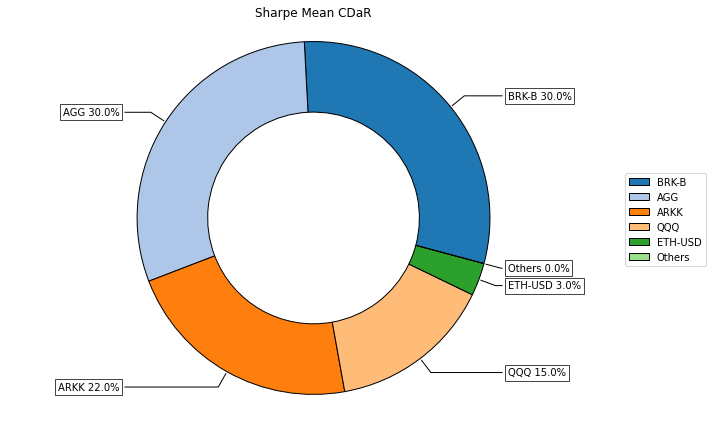

In [89]:
# Plotting the composition of the last CDaR portfolio
w = pd.DataFrame(models['CDaR'].iloc[-1,:])

ax = plf.plot_pie(w=w, title='Sharpe Mean CDaR', others=0.02, nrow=25, cmap = "tab20",
                  height=6, width=10, ax=None)